# SED of electrons from the Bethe-Heitler pair production process

## Importing relevant libraries

In [2]:
import numpy as np

import astropy.units as u
from astropy.constants import m_e, m_p, e, h, c, k_B, alpha, sigma_T
from astropy.coordinates import Distance
import matplotlib.pyplot as plt
from IPython.display import Image

from scipy import integrate

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Constants

In [4]:
N_size = 100        # Number of elements in the arrays

# Constants
    
beta_m = 0.9999
beta_p = 0.9999
Z = 1.
r0 = 2.8179e-15     # m2
T_cmb = 2.7 * u.K   # K
mec2 = m_e.to(u.eV, equivalencies=u.mass_energy()) # 511 keV
mpc2 = m_p.to(u.eV, equivalencies=u.mass_energy()) # 938 MeV

# Proton energies

E_p_1 = 6.4*10.**19 * u.eV   # eV
E_p_2 = 10.**20 * u.eV       # eV
E_p_3 = 3*10.**20 * u.eV     # eV
gamma_p_1 = E_p_1/mpc2
gamma_p_2 = E_p_2/mpc2
gamma_p_3 = E_p_3/mpc2

# Fudge factors (upper integration limits)

fudge_1 = 10000.
fudge_2 = 100000.
fudge_3 = 1000000.
fudge_4 = 10000000.

In [5]:
def logspace_array(start, stop, size):
    start = float(np.log10(start))
    stop = float(np.log10(stop))
    return np.logspace(start, stop, size)

## Differential cross section

Rewritten version of Blumenthal (1970) can be found in Jiménez-Fernández & van Eerten (2021)

Notation in paper:
- $\gamma_e$: energy of final electron (positron)
- $\gamma_p$: energy of initial proton
- $\gamma_{+/-}$: energy of positron/electron in rest frame of proton
- $\omega = \gamma_p + \gamma_m$: energy of photon in rest frame of proton

Notation in code below:
- _m: minus
- _p: plus
- E_m = $\gamma_-$ (since $E_m$ defined in units of $m_ec^2$)
- E_p = $\gamma_+$ (since $E_p$ defined in units of $m_pc^2$)

In [6]:
def create_cross_section(E_proton, E_electron, E_m, p_m, omega):

    E_p = omega - E_m
    p_p = create_p(E_p, beta_p)
            
    # Functions
        
    theta_m = np.arccos((E_proton*E_m - E_electron)/(E_proton*E_m))
    
    Delta_m = E_electron/E_proton
    T = np.sqrt(p_p**2 + 2*omega*Delta_m)
    Y = 2*np.log((E_m*E_p + p_m*p_p + 1)/(omega))/(p_m**2)
    y_p = 2*np.arctanh(beta_m)/p_p
    delta_T_p = np.log(1 + (p_p*(p_p + T)/(omega*Delta_m)))

    # Cross section terms
    
    prefactor = (alpha.value*(Z**2)*(r0**2)*p_m*p_p)/(2*omega**3)
    
    term1 = 4*np.sin(theta_m)**2*(2*E_m**2 + 1)/(p_m**2*Delta_m**4)
    term2 = (5*E_m**2 - 2*E_p*E_m + 3) / (p_m**2*Delta_m**2)
    term3 = (p_m**2 - omega**2)/(T**2*Delta_m**2)
    term4 = (2*E_p)/(p_m**2*Delta_m)
    
    term5 = Y/(p_m*p_p)
    term6 = 2*E_m*np.sin(theta_m)**2*(3*omega + p_m**2*E_p)/(Delta_m**4)
    term7 = (2*E_m**2*(E_m**2 + E_p**2) - 7*E_m**2 - 3*E_p*E_m - E_p**2 + 1)/(Delta_m**2)
    term8 = omega*(E_m**2 - E_m*E_p - 1)/Delta_m
    
    term9 = delta_T_p/(p_p*T)
    term10 = 2/(Delta_m**2)
    term11 = (3*omega)/Delta_m
    term12 = omega*(p_m**2 - omega**2)/(T**2*Delta_m)
    
    term13 = (2*y_p)/Delta_m
    
    # Total cross section

    return prefactor*(-term1+term2+term3+term4
                       +term5*(term6+term7+term8)
                       -term9*(term10-term11-term12)
                       -term13)

## Terms used in second integral

In [7]:
def create_p(E, beta):   # Rewritten version of energy-momentum relation
    return beta*E

def create_E_m(gamma_p, E_e, omega):
    E_m_min = (gamma_p**2 + E_e**2)/(2*gamma_p*E_e)    # Lower integration limit second integral
    E_m_max = omega - 1                                # Upper integration limit second integral
    return logspace_array(E_m_min, E_m_max, N_size)

## Terms used in first integral

In [8]:
def create_omega(gamma_p, E_e, fudge):
    omega_min = ((gamma_p + E_e)**2)/(2*gamma_p*E_e) # Lower integration limit first integral
    omega_max = fudge                                # Upper intergation limit first integral
    return logspace_array(omega_min, omega_max, N_size)

def create_ln(gamma_p, omega):
    exponent_low = (2*gamma_p*k_B*T_cmb).to(u.eV)/mec2
    exponent = - omega / exponent_low
    return np.log(1 - np.exp(exponent))

## Main loop

In [9]:
def evaluate_BH(gamma_p, E_e_array, fudge):
    
    prefactor = (-(k_B*T_cmb).to(u.eV) / (2*np.pi**2*gamma_p**3))/mec2
    
    first_integral_array = np.zeros(N_size)
    for i, E_e in enumerate(E_e_array):
        
        omega_array = create_omega(gamma_p, E_e, fudge)
        ln_array = create_ln(gamma_p, omega_array)
        
        second_integral_array = np.zeros(N_size)
        for j, omg in enumerate(omega_array):
                        
            E_m_array = create_E_m(gamma_p, E_e, omg)
            p_m_array = create_p(E_m_array, beta_m)
            
            W = create_cross_section(gamma_p, E_e, E_m_array, p_m_array, omg)
            
            second_integrand = p_m_array**-1 * W
            second_integral = integrate.trapz(second_integrand, x=E_m_array)
            second_integral_array[j] = second_integral
        
        first_integrand = omega_array * ln_array * second_integral_array
        first_integral = integrate.trapz(first_integrand, x=omega_array)
        first_integral_array[i] = first_integral
    
    return prefactor * first_integral_array

## Running and plotting

In [10]:
E_e_array = logspace_array(10.**12, 10.**23, N_size) # Arbitrary array of electron energies
E_e_array_dim = E_e_array/mec2.value                 # Electron energies in units of mec2

dN_dE_gamma1 = evaluate_BH(gamma_p_1, E_e_array_dim, fudge_4)
dN_dE_gamma2 = evaluate_BH(gamma_p_2, E_e_array_dim, fudge_4)
dN_dE_gamma3 = evaluate_BH(gamma_p_3, E_e_array_dim, fudge_4)

In [11]:
# Traced over curves in Fig. (10) in Kelner & Aharonian (2009) for comparable results

#data1=np.genfromtxt("SED_gamma1.txt")
#data2=np.genfromtxt("SED_gamma2.txt")
#data3=np.genfromtxt("SED_gamma3.txt")

#def extract(array, index):
#    return array[:,index]

#data_E_gamma1 = extract(data1, 0)
#data_E_gamma2 = extract(data2, 0)
#data_E_gamma3 = extract(data3, 0)

#data_E2_dN_dE_gamma1 = extract(data1, 1)
#data_E2_dN_dE_gamma2 = extract(data2, 1)
#data_E2_dN_dE_gamma3 = extract(data3, 1)

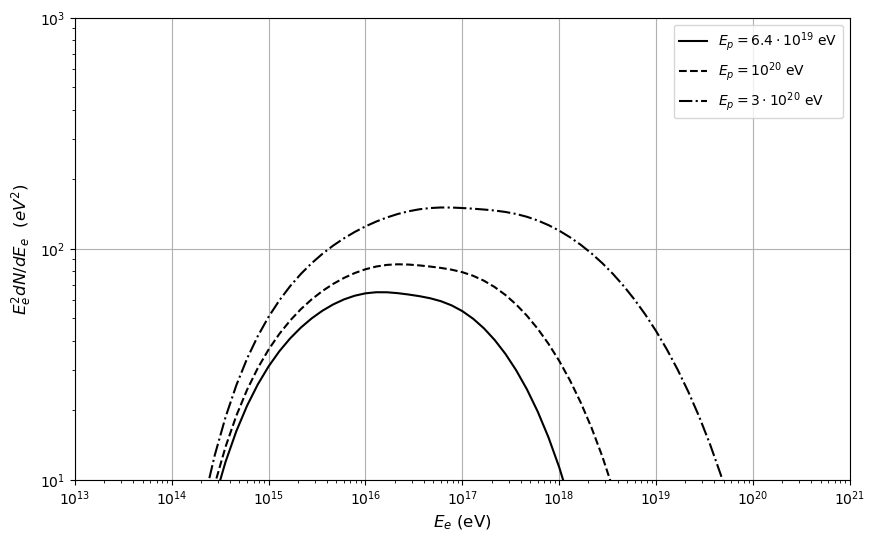

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

#plt.loglog(data_E_gamma1, data_E2_dN_dE_gamma1, ":k")
#plt.loglog(data_E_gamma2, data_E2_dN_dE_gamma2, ":k")
#plt.loglog(data_E_gamma3, data_E2_dN_dE_gamma3, ":k")

scaling_factor = 1.4*10.**11 # Scaling factor to have comparable results

plt.loglog(E_e_array, scaling_factor*(r0**-2)*dN_dE_gamma1*E_e_array**2, "-k", label=r"$E_p = 6.4 \cdot 10^{19}$ eV")
plt.loglog(E_e_array, scaling_factor*(r0**-2)*dN_dE_gamma2*E_e_array**2, "--k", label=r"$E_p = 10^{20}$ eV")
plt.loglog(E_e_array, scaling_factor*(r0**-2)*dN_dE_gamma3*E_e_array**2, "-.k", label=r"$E_p = 3 \cdot 10^{20}$ eV")

plt.xlim(10.**13, 10.**21)
plt.ylim(10.**1, 10.**3)
plt.ylabel(r"$E_e^2 dN/dE_e$  $(eV^2)$", fontsize=12)
plt.xlabel("$E_e$ (eV)", fontsize=12)
plt.legend()
plt.grid()
plt.show()

## $\omega_{max}$ vs. $\omega_{min}$

In [23]:
omega_arrays_gamma1 = np.array([create_omega(gamma_p_1, E_e, fudge_4) for E_e in E_e_array_dim])
omega_mins = omega_arrays_gamma1[:,0]
omega_maxs = omega_arrays_gamma1[:,-1]

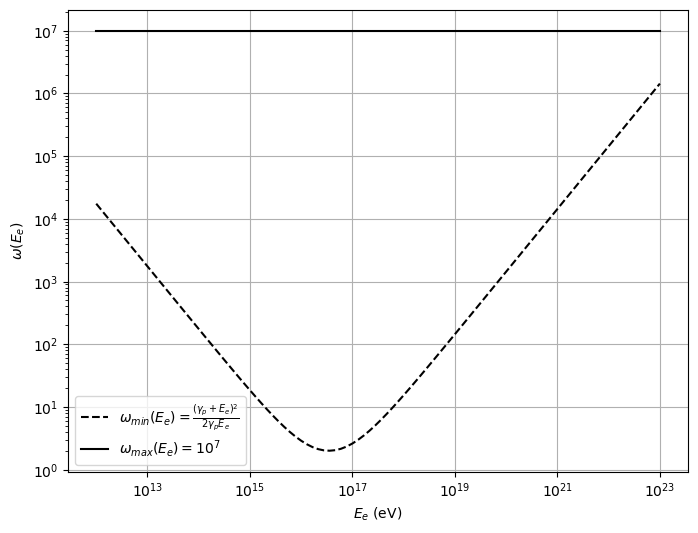

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.loglog(E_e_array, omega_mins, "--k", label=r"$\omega_{min}(E_e) = \frac{(\gamma_p+E_e)^2}{2\gamma_pE_e}$")
plt.loglog(E_e_array, omega_maxs, "-k", label=r"$\omega_{max}(E_e) = 10^7$")

plt.ylabel(r"$\omega(E_e)$")
plt.xlabel("$E_e$ (eV)")
plt.grid()
plt.legend()
plt.show()

## $W(\omega, E_-, \xi)$

In [21]:
E_es_array = np.array([E_e_array_dim[40], E_e_array_dim[42], E_e_array_dim[44], E_e_array_dim[46]])

def extract_W(E_e):
    
    omega_array = create_omega(gamma_p_1, E_e, fudge_4)
    omegas = np.array([omega_array[10], omega_array[11], omega_array[12], omega_array[13]])
    
    cross_sections = np.array([np.zeros(N_size), np.zeros(N_size), np.zeros(N_size), np.zeros(N_size)])  
    E_ms = np.array([np.zeros(N_size), np.zeros(N_size), np.zeros(N_size), np.zeros(N_size)])    
    for i, omg in enumerate(omegas):
        
        E_m = create_E_m(gamma_p_1, E_e, omg)
        p_m = create_p(E_m, beta_m)
        W = create_cross_section(gamma_p_1, E_e, E_m, p_m, omg) / r0**2
        cross_sections[i] = np.array(W)
        E_ms[i] = E_m
    
    return E_ms, cross_sections, omegas

E_m0, W0, omega0 = extract_W(E_es_array[0])
E_m1, W1, omega1 = extract_W(E_es_array[1])
E_m2, W2, omega2 = extract_W(E_es_array[2])
E_m3, W3, omega3 = extract_W(E_es_array[3])

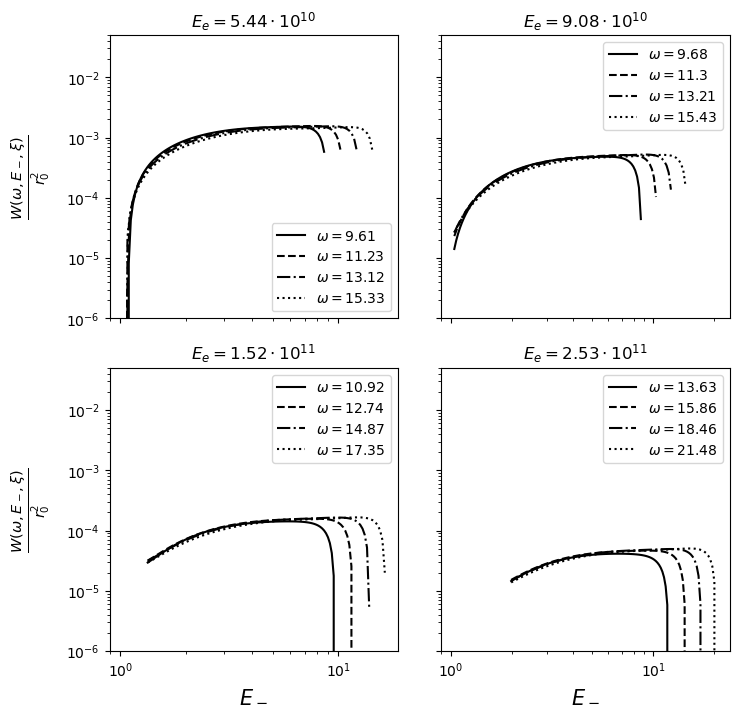

In [22]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2, hspace=0.175, wspace=0.15)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

styles = ["-", "--", "-.", ":"]
titles = [r"$5.44\cdot 10^{10}$", r"$9.08 \cdot 10^{10}$", r"$1.52 \cdot 10^{11}$", r"$2.53 \cdot 10^{11}$"]

i = 0
for E_m, W, omega in zip(E_m0, W0, omega0):
    ax1.loglog(E_m, W, color="k", linestyle=styles[i], label=r"$\omega = $" + f"{round(omega, 2)}")
    ax1.legend()
    ax1.set_title(r"$E_e =$" + f"{titles[0]}")
    ax1.set_ylabel(r"$\frac{W(\omega, E_-, \xi)}{r_0^2}$", fontsize=15, rotation=90, labelpad=10)
    ax1.set_ylim(10.**(-6), 5*10.**(-2))
    i += 1

i = 0
for E_m, W, omega in zip(E_m1, W1, omega1):
    ax2.loglog(E_m, W, color="k", linestyle=styles[i], label=r"$\omega = $" + f"{round(omega, 2)}")
    ax2.legend()
    ax2.set_title(r"$E_e =$" + f"{titles[1]}")
    ax2.set_ylim(10.**(-6), 5*10.**(-2))
    i += 1
    
i = 0
for E_m, W, omega in zip(E_m2, W2, omega2):
    ax3.loglog(E_m, W, color="k", linestyle=styles[i], label=r"$\omega = $" + f"{round(omega, 2)}")
    ax3.legend()
    ax3.set_title(r"$E_e =$" + f"{titles[2]}")
    ax3.set_ylabel(r"$\frac{W(\omega, E_-, \xi)}{r_0^2}$", fontsize=15, rotation=90, labelpad=10)
    ax3.set_xlabel(r"$E_-$", fontsize=15)
    ax3.set_ylim(10.**(-6), 5*10.**(-2))
    i += 1
    
i = 0
for E_m, W, omega in zip(E_m3, W3, omega3):
    ax4.loglog(E_m, W, color="k", linestyle=styles[i], label=r"$\omega = $" + f"{round(omega, 2)}")
    ax4.legend()
    ax4.set_title(r"$E_e =$" + f"{titles[3]}")
    ax4.set_xlabel(r"$E_-$", fontsize=15)    
    ax4.set_ylim(10.**(-6), 5*10.**(-2))
    i += 1
    
for ax in fig.get_axes():
    ax.label_outer()

## Fudge factor (upper integration limit $\omega_{max}$)

In [19]:
dN_dE_gamma1_fudge1 = evaluate_BH(gamma_p_1, E_e_array_dim, fudge_4)
dN_dE_gamma1_fudge2 = evaluate_BH(gamma_p_1, E_e_array_dim, 10*fudge_4)
dN_dE_gamma1_fudge3 = evaluate_BH(gamma_p_1, E_e_array_dim, 100*fudge_4)
dN_dE_gamma1_fudge4 = evaluate_BH(gamma_p_1, E_e_array_dim, 1000*fudge_4)

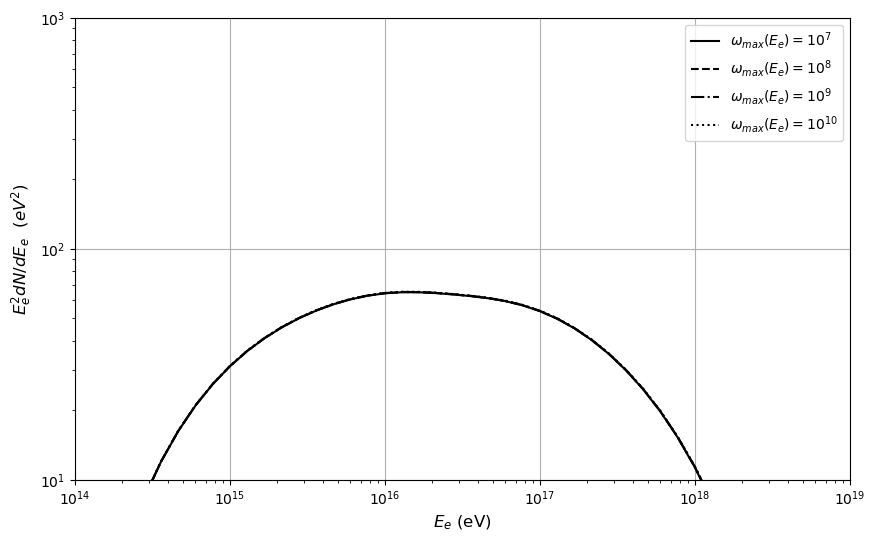

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.loglog(E_e_array, scaling_factor*(r0**-2)*dN_dE_gamma1_fudge1*E_e_array**2, "-k", label=r"$\omega_{max}(E_e)=10^{7}$")
plt.loglog(E_e_array, scaling_factor*(r0**-2)*dN_dE_gamma1_fudge2*E_e_array**2, "--k", label=r"$\omega_{max}(E_e)=10^{8}$")
plt.loglog(E_e_array, scaling_factor*(r0**-2)*dN_dE_gamma1_fudge3*E_e_array**2, "-.k", label=r"$\omega_{max}(E_e)=10^{9}$")
plt.loglog(E_e_array, scaling_factor*(r0**-2)*dN_dE_gamma1_fudge4*E_e_array**2, ":k", label=r"$\omega_{max}(E_e)=10^{10}$")

plt.xlim(10.**14, 10.**19)
plt.ylim(10.**1, 10.**3)
plt.ylabel(r"$E_e^2 dN/dE_e$  $(eV^2)$", fontsize=12)
plt.xlabel("$E_e$ (eV)", fontsize=12)
plt.legend()
plt.grid()
plt.show()